### Acquiring the data from Athena/Periscope
This Athena/data pipeline query gets the rental customer_id, the booked_at, and ended_at.  Specifically, it looks at the latest RENTAL_LIFECYCLE event from sa_object_changed.

Added filters include:
* tenant is eiffel-prod
* rental ended 
* rental has booked_at value
* rental has ended_at value
* rental within the Periscope datarange filter
* service is the ZITY service (main public service)


```sql
SELECT 
  "object_data-customer_id",
  "object_data-rental_booked_at",
  "object_data-rental_ended_at"
FROM 
(
  SELECT 
--     "tenant_id",
--     "object_data-rental_id",
--     from_iso8601_timestamp(timestamp) AS "timestamp",
    row_number() OVER (partition by "object_data-rental_id" ORDER BY  from_iso8601_timestamp(timestamp) desc) AS seqnum, 
    "object_data-customer_id", 
    "object_data-rental_booked_at", 
    "object_data-rental_ended_at"
  FROM 
    "data_lake_eu_prod"."sa_object_changed"
  WHERE 
    "name" = 'RENTAL_LIFECYCLE' 
    and "tenant_id" = 'eiffel-prod'
    and "object_data-status" = 'ENDED'  -- only completed bookings
    and "object_data-rental_booked_at" is not null
    and "object_data-rental_ended_at" is not null
    and [from_iso8601_timestamp("object_data-rental_reserved_at")=daterange]
    and "object_data-service_id" = 5  -- ZITY service
  ORDER BY
    1
) t
WHERE
  t.seqnum = 1  -- get the latest RENTAL_LIFECYCLE entry, by rental_id
```
Export this data a comma-separated values (CSV) file.

### Read in the data exported from Athena/Periscope


In [1]:
import pandas as pd

# rentals = pd.read_csv('UntitledChart_2019-6-4_1358.csv')
rentals = pd.read_csv('UntitledChart_2019-6-7_1531.csv')

# create a new column with the timestamp correctly parsed as UTC and then converted to Madrid
rentals['booked_at'] = pd.to_datetime(rentals['object_data-rental_booked_at']).dt.tz_localize('UTC').dt.tz_convert('Europe/Madrid')
rentals['end_datetime'] = pd.to_datetime(rentals['object_data-rental_ended_at']).dt.tz_localize('UTC').dt.tz_convert('Europe/Madrid')
rentals.drop(['object_data-rental_booked_at', 'object_data-rental_ended_at'], axis=1, inplace=True)  # remove the original column
rentals.rename(columns={'object_data-customer_id': 'customer_id'}, inplace=True)

rentals.head()

,customer_id,booked_at,end_datetime
0,228996,2019-05-29 17:39:24.026685+02:00,2019-05-29 18:04:27.652201+02:00
1,180038,2019-05-29 18:00:56.419880+02:00,2019-05-29 18:15:29.491876+02:00
2,6813,2019-05-20 14:50:08.289332+02:00,2019-05-20 14:51:47.299094+02:00
3,223781,2019-05-20 23:41:41.834583+02:00,2019-05-20 23:42:05.264161+02:00
4,25837,2019-05-30 06:39:54.681279+02:00,2019-05-30 06:57:39.689848+02:00


### Calculate values
#### based on minutes

In [2]:
import pandas as pd
import numpy as np

# sum up the minutes between booked_at and end_datetime and distribute them into columns for every day of the week 
rental_minutes = rentals.apply(lambda x: pd.date_range(x['booked_at'], x['end_datetime'], freq='min').weekday_name.value_counts(), axis=1)
rental_minutes.fillna(value=0, inplace=True)  # replace NaNs with 0s
rentals = rentals.merge(rental_minutes, left_index=True, right_index=True)  # merge the original data and the new date data

In [3]:
customer_totals = rentals.groupby('customer_id').sum()  # for each customer, sum up their minutes (in each weekday column)
# assumes we have data for each day of the week!
# print(customer_totals)
customer_totals['weekday_minutes'] = customer_totals['Monday'] + customer_totals['Tuesday'] + customer_totals['Wednesday'] + customer_totals['Thursday'] + customer_totals['Friday']
customer_totals['weekend_minutes'] = customer_totals['Saturday'] + customer_totals['Sunday']
customer_totals['weekend_mins_to_rental_mins'] = customer_totals['weekend_minutes'] / (customer_totals['weekday_minutes'] + customer_totals['weekend_minutes'])
# customer_totals.head()
customer_totals = customer_totals.replace(np.inf, 0)

customer_totals['weekend_mins_to_rental_mins'].describe()

count    43975.000000
mean         0.323723
std          0.409315
min          0.000000
25%          0.000000
50%          0.000000
75%          0.681818
max          1.000000
Name: weekend_mins_to_rental_mins, dtype: float64

In [4]:
# also calculate how many weekend minutes were possible during the time period in question
# caveat: these calculations will be inaccurate if there's a really long rental which ends much later because the original SQL query just filters on booked_at, not end_datetime
min_cts = pd.date_range(rentals['booked_at'].min(), rentals['end_datetime'].max(), freq='min').weekday_name.value_counts()
customer_totals['weekday_minutes_fraction'] = customer_totals['weekday_minutes'] / (min_cts['Monday'] + min_cts['Tuesday'] + min_cts['Wednesday'] + min_cts['Thursday'] + min_cts['Friday'])
customer_totals['weekend_minutes_fraction'] = customer_totals['weekend_minutes'] / (min_cts['Saturday'] + min_cts['Sunday'])
customer_totals.head()

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,weekday_minutes,weekend_minutes,weekend_mins_to_rental_mins,weekday_minutes_fraction,weekend_minutes_fraction
customer_id,,,,,,,,,,,,
34,855.0,112.0,0.0,0.0,653.0,0.0,223.0,1843.0,0.0,0.000000,0.054734,0.000000
99,147.0,0.0,498.0,106.0,704.0,0.0,0.0,851.0,604.0,0.415120,0.025273,0.041944
100,14.0,0.0,0.0,0.0,0.0,0.0,12.0,26.0,0.0,0.000000,0.000772,0.000000
101,76.0,0.0,19.0,10.0,0.0,25.0,149.0,250.0,29.0,0.103943,0.007425,0.002014
130,80.0,274.0,0.0,0.0,0.0,0.0,0.0,354.0,0.0,0.000000,0.010513,0.000000


#### based on rentals

In [5]:
# sum rentals on weekdays and weekends
rentals['weekday_name'] = rentals['booked_at'].dt.weekday_name
rental_counts_by_dow = rentals.groupby('customer_id')['weekday_name'].value_counts().unstack().fillna(0)
customer_totals2 = customer_totals.merge(rental_counts_by_dow, left_index=True, right_index=True, suffixes=('_minutes','_count'))  # merge the original data and the new date data

customer_totals2['weekday_count'] = customer_totals2['Monday_count'] + customer_totals2['Tuesday_count'] + customer_totals2['Wednesday_count'] + customer_totals2['Thursday_count'] + customer_totals2['Friday_count']
customer_totals2['weekend_count'] = customer_totals2['Saturday_count'] + customer_totals2['Sunday_count']
customer_totals2['weekend_count_ratio'] = customer_totals2['weekend_count'] / (customer_totals2['weekend_count'] + customer_totals2['weekday_count'])
customer_totals2.head()

,Friday_minutes,Monday_minutes,Saturday_minutes,Sunday_minutes,Thursday_minutes,Tuesday_minutes,Wednesday_minutes,weekday_minutes,weekend_minutes,weekend_mins_to_rental_mins,...,Friday_count,Monday_count,Saturday_count,Sunday_count,Thursday_count,Tuesday_count,Wednesday_count,weekday_count,weekend_count,weekend_count_ratio
customer_id,,,,,,,,,,,,,,,,,,,,,
34,855.0,112.0,0.0,0.0,653.0,0.0,223.0,1843.0,0.0,0.000000,...,4.0,1.0,0.0,0.0,4.0,0.0,1.0,10.0,0.0,0.000000
99,147.0,0.0,498.0,106.0,704.0,0.0,0.0,851.0,604.0,0.415120,...,1.0,0.0,2.0,2.0,2.0,0.0,0.0,3.0,4.0,0.571429
100,14.0,0.0,0.0,0.0,0.0,0.0,12.0,26.0,0.0,0.000000,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.000000
101,76.0,0.0,19.0,10.0,0.0,25.0,149.0,250.0,29.0,0.103943,...,3.0,0.0,1.0,1.0,0.0,1.0,2.0,6.0,2.0,0.250000
130,80.0,274.0,0.0,0.0,0.0,0.0,0.0,354.0,0.0,0.000000,...,1.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.000000


#### based on minutes per week

In [6]:
# On average, what percentage of the weekend do they rent (out of the whole weekend)?
# get avg # of weekday hours used per week (of total time frame)
# customer_totals.sort_values(by=['weekday_minutes'], ascending=False)['weekday_minutes']


### Determine if the customer is a weekdayer or weekender

In [7]:
# simple majority calculation (weekender if the majority of their rental minutes are during the weekend)
customer_totals2['weekender_by_minutes'] = customer_totals2['weekend_mins_to_rental_mins'] > 0.5
customer_totals2['weekender_by_count'] = customer_totals2['weekend_count_ratio'] > 0.5
#customer_totals2.head(5)

In [8]:
# discrepencies between the two classification methods
customer_totals2[customer_totals2['weekender_by_minutes'] != customer_totals2['weekender_by_count']][['weekday_minutes', 'weekend_minutes', 'weekend_mins_to_rental_mins', 'weekday_minutes_fraction', 'weekend_minutes_fraction', 'weekday_count', 'weekend_count', 'weekend_count_ratio', 'weekender_by_minutes', 'weekender_by_count']].head(5)

,weekday_minutes,weekend_minutes,weekend_mins_to_rental_mins,weekday_minutes_fraction,weekend_minutes_fraction,weekday_count,weekend_count,weekend_count_ratio,weekender_by_minutes,weekender_by_count
customer_id,,,,,,,,,,
99,851.0,604.0,0.415120,0.025273,0.041944,3.0,4.0,0.571429,False,True
558,12.0,19.0,0.612903,0.000356,0.001319,1.0,1.0,0.500000,True,False
563,18.0,28.0,0.608696,0.000535,0.001944,1.0,1.0,0.500000,True,False
731,34.0,37.0,0.521127,0.001010,0.002569,1.0,1.0,0.500000,True,False
926,58.0,26.0,0.309524,0.001722,0.001806,7.0,10.0,0.588235,False,True


### Plots

#### 
Let's try to determine weekenders by looking at either:
* When they have the majority of their rental minutes
* When they started the majority of their rentals (weekdays vs. weekends)

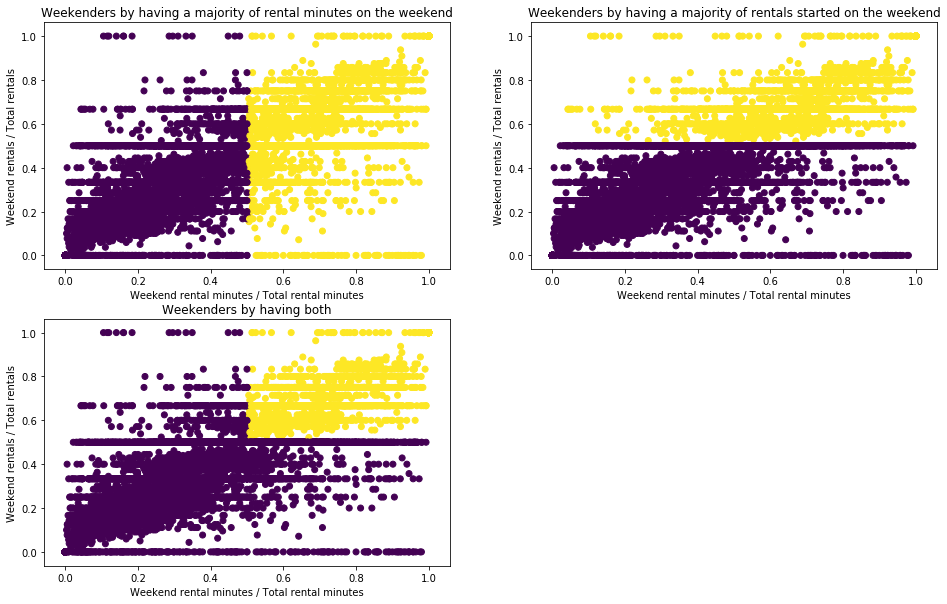

In [56]:
# plot one method vs the other
import matplotlib.pyplot as plt


plt.figure(figsize=(16,10))
plt.subplot(2, 2, 1)
plt.title('Weekenders by having a majority of rental minutes on the weekend')
plt.scatter(customer_totals2['weekend_mins_to_rental_mins'], customer_totals2['weekend_count_ratio'], c=customer_totals2['weekender_by_minutes'])
plt.xlabel('Weekend rental minutes / Total rental minutes')
plt.ylabel('Weekend rentals / Total rentals')

plt.subplot(2, 2, 2)
plt.title('Weekenders by having a majority of rentals started on the weekend')
plt.scatter(customer_totals2['weekend_mins_to_rental_mins'], customer_totals2['weekend_count_ratio'], c=customer_totals2['weekender_by_count'])
plt.xlabel('Weekend rental minutes / Total rental minutes')
plt.ylabel('Weekend rentals / Total rentals')

plt.subplot(2, 2, 3)
plt.title('Weekenders by having both')
plt.scatter(customer_totals2['weekend_mins_to_rental_mins'], customer_totals2['weekend_count_ratio'], c=customer_totals2['weekender_by_minutes'] & customer_totals2['weekender_by_count'])
plt.xlabel('Weekend rental minutes / Total rental minutes')
plt.ylabel('Weekend rentals / Total rentals')

plt.show()

#### Histogram of the weekday-to-total-rental-minutes fraction
This is the ratio of weekday minutes to total rental customer minutes.  It looks like it is centered around customers renting "equally" with regards to weekdays/weekends (most customers have rental minutes on the weekend around 5/7=71% of the time). 

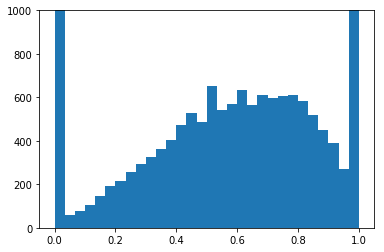

In [16]:
# histogram of the "weekend minute ratio"
n, bins, patches = plt.hist(1-customer_totals2['weekend_mins_to_rental_mins'], bins=30)
plt.ylim([0, 1000])
plt.show()

#### Histogram of the weekday minute fraction
Let's look at which fraction of the available weekday minutes customers rent for.  A majority rent for a very small fraction of the weekdays (< 0.08%).  A very small subset rents for a large portion of the weekdays (15-30%).  There are plenty of customers who could be targetted to increase their weekday useage.

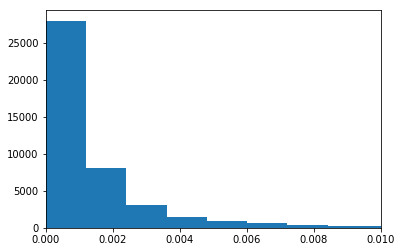

count    43975.000000
mean         0.001838
std          0.004960
min          0.000000
25%          0.000297
50%          0.000802
75%          0.001782
max          0.360834
Name: weekday_minutes_fraction, dtype: float64
customer_id
204986    0.360834
8672      0.248307
152740    0.180833
79394     0.151847
158422    0.150244
Name: weekday_minutes_fraction, dtype: float64


In [72]:
# histogram of how many of the available weekday minutes customers rent
n, bins, patches = plt.hist(customer_totals2['weekday_minutes_fraction'], bins=300)
plt.xlim([0, 0.01])
plt.show()
print(customer_totals2['weekday_minutes_fraction'].describe())
print(customer_totals2.sort_values(by=['weekday_minutes_fraction'], ascending=False)['weekday_minutes_fraction'].head())

#### Weekday bucketing

In [81]:
# split the customers into quarters based on weekday_minutes_fraction
customer_totals2['weekday_minutes_fraction_rank'] = pd.qcut(customer_totals2['weekday_minutes_fraction'], 4, labels=[1, 2, 3, 4])
customer_totals2[['weekday_minutes_fraction_rank', 'weekday_minutes_fraction']].head()

,weekday_minutes_fraction_rank,weekday_minutes_fraction
customer_id,,
34,4,0.054734
99,4,0.025273
100,2,0.000772
101,4,0.007425
130,4,0.010513


#### Weekend bucketing
Hard to bucket/break up by weekend minutes because so many customers are at 0.  If greater than 50% of the customers have 0 weekend minutes/rentals, it is hard to decide which are the lowest 50% if they're all 0.

In [84]:
customer_totals2['weekend_minutes_fraction'].describe()

count    43975.000000
mean         0.001823
std          0.006493
min          0.000000
25%          0.000000
50%          0.000000
75%          0.001875
max          0.345347
Name: weekend_minutes_fraction, dtype: float64

In [87]:
customer_totals2[customer_totals2['weekend_minutes_fraction'] > 0]['weekend_minutes_fraction'].describe()

count    21089.000000
mean         0.003801
std          0.008965
min          0.000069
25%          0.001250
50%          0.001944
75%          0.003542
max          0.345347
Name: weekend_minutes_fraction, dtype: float64